In [9]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [10]:
rootfolder = '../'

Useful function for plot the 2D DCT dictionary

In [11]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [12]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  # residual
  r = s - np.dot(D, x)
  resNorm = np.linalg.norm(r)

  # support set
  omega = []
  while np.count_nonzero(x) < L and resNorm > tau: #STOPPING CRITERIA:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        zj = np.dot(r.T,D[:,j])/np.linalg.norm(D[:,j])**2
        e[j] = np.linalg.norm(r) - zj

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x[omega] = np.dot(np.linalg.inv((D[:,omega].T @ D[:,omega])),D[:,omega].T @ s)

    # update the residual
    r = s - np.dot(D, x)
    resNorm = np.linalg.norm(r)


  return x

Load the image and rescale it in $[0,1]$

In [13]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Extract a bunch of random patches from the image

In [14]:
npatch = 10000

S = np.zeros((M, npatch))
for i in range(npatch):
    x = np.random.randint(0, imsz[0] - p)
    y = np.random.randint(0, imsz[1] - p)
    S[:, i] = img[x:x + p, y:y + p].flatten()  

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [15]:
S -= np.mean(S, axis=0)


Initialize the dictionary and the coefficient matrix

In [16]:
# number of columns of the dictionary
N = 256

# intialize the dictionary
D = np.random.randn(M, N)

# normalize each column of D (zero mean and unit norm)
# UPDATE D
D -= - np.mean(D, axis=0)
D /= np.linalg.norm(D, axis=0)

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))


Main KSVD loop


In [17]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
        X[:, n] = OMP(S[:, n], D, L, 1e-3)
    
    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.where(X[j, :] != 0)[0]

        if len(omega) == 0:
            # if the atom is never used then ignore or substitute it with a random vector
            D[:, j] = np.random.randn(M)
        else:
            # compute the residual matrix E, ignoring the j-th atom
            not_j = list(set(range(N)) - {j}) 

            D_not_j = D[:, not_j]
            X_not_j = X[not_j, :]

            E = S - D_not_j @ X_not_j

            # restrict E to the columns indicated by omega
            Eomega = E[:,omega]

            # compute the SVD of Eomega
            U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)

            # update the dictionary
            D[:,j] = U[:,0]

            # update the coefficient matrix
            X[j, omega] = Sigma[0] * V[0,:]
    
    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0
205
iter 1
215
iter 2
189
iter 3
201
iter 4
200
iter 5
222
iter 6
212
iter 7
211
iter 8
251
iter 9
308


Show the learned dictionary

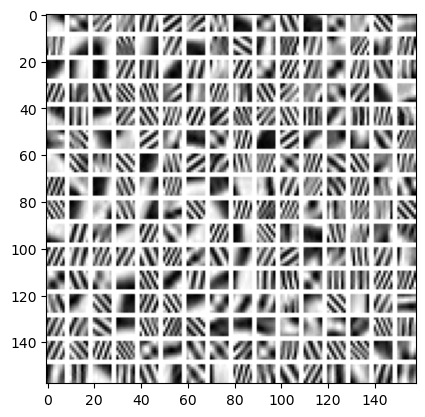

In [18]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')